In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt


In [2]:
from sklearn.datasets import make_blobs


In [3]:
def generate_gaussian_data(n_samples=1000, mean=[0, 0], cov=[[1, 0],
                                                              [0, 1]]):
    data = np.random.multivariate_normal(mean, cov, n_samples)
    return torch.tensor(data, dtype=torch.float32)


In [4]:
def generate_anisotropic_single_gaussian(n_samples=1000):
    X, _ = make_blobs(n_samples=n_samples, centers=1, random_state=42)
    transformation_matrix = np.array(
        [[0.6, -0.6], [-0.4, 0.8]]
    )  # This creates an anisotropic effect
    data = np.dot(X, transformation_matrix)
    return torch.tensor(data, dtype=torch.float32)


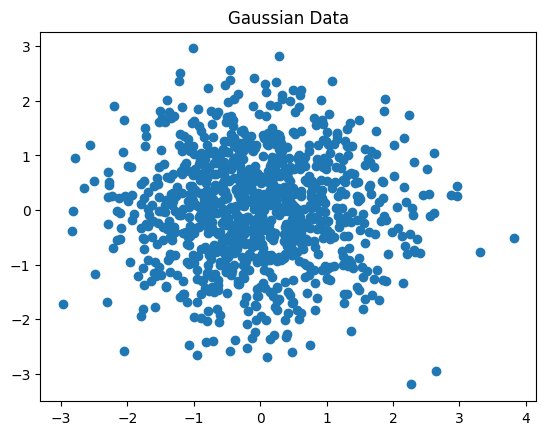

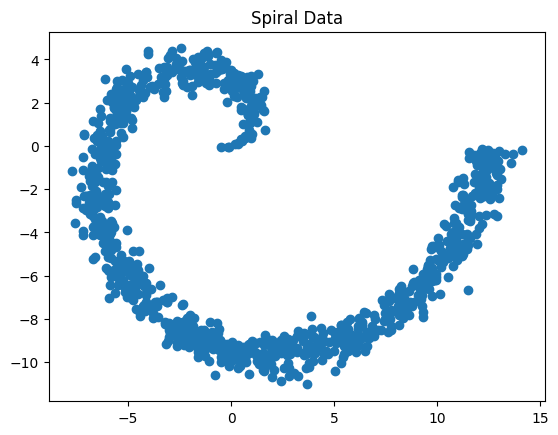

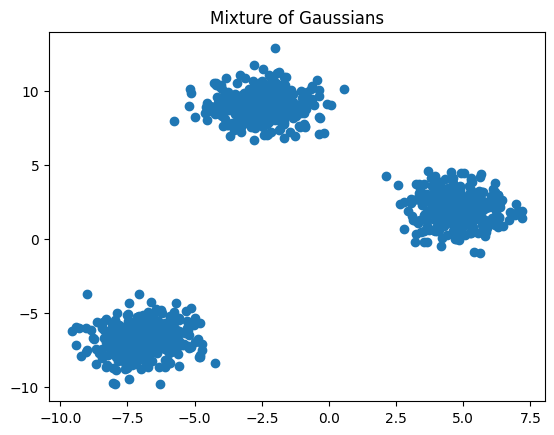

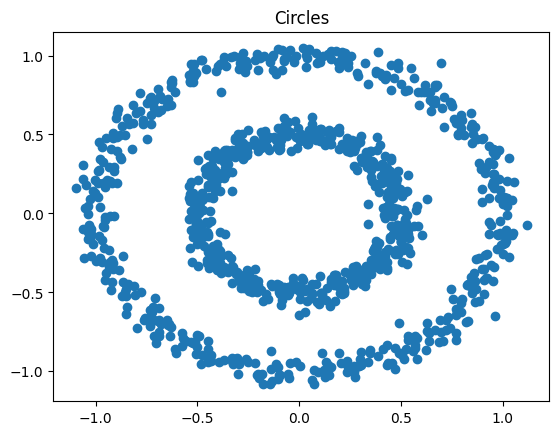

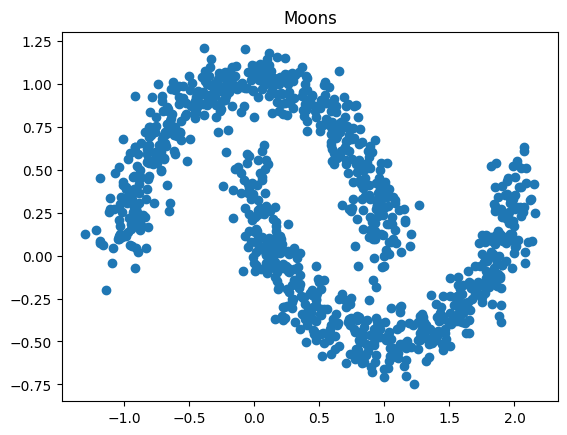

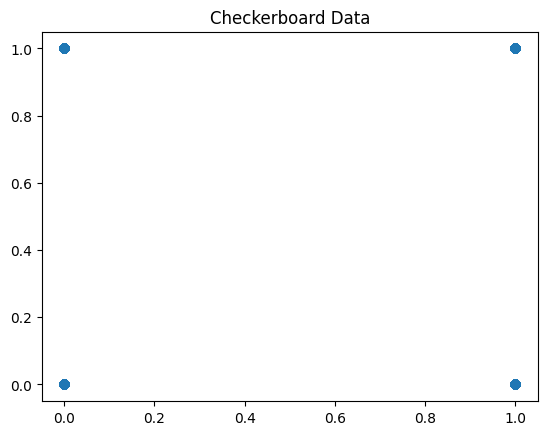

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons, make_blobs

# Gaussian Data
def generate_gaussian_data(n_samples=1000, n_features=2):
    mean = np.zeros(n_features)
    cov = np.eye(n_features)
    return np.random.multivariate_normal(mean, cov, n_samples)

# Spiral Data
def generate_spiral_data(n_samples=1000, noise=0.5):
    theta = np.sqrt(np.random.rand(n_samples)) * 2 * np.pi
    r = 2 * theta + noise * np.random.randn(n_samples)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.vstack((x, y)).T

# Mixture of Gaussians
def generate_mixture_of_gaussians(n_samples=1000, n_components=3):
    X, _ = make_blobs(n_samples=n_samples, centers=n_components, random_state=42)
    return X

# Circles
def generate_circles(n_samples=1000, noise=0.05):
    X, _ = make_circles(n_samples=n_samples, noise=noise, factor=0.5)
    return X

# Moons
def generate_moons(n_samples=1000, noise=0.1):
    X, _ = make_moons(n_samples=n_samples, noise=noise)
    return X

# Checkerboard Data
def generate_checkerboard_data(n_samples=1000):
    x1 = np.random.rand(n_samples)
    x2 = np.random.rand(n_samples)
    x1 = (x1 * 8).astype(int) % 2
    x2 = (x2 * 8).astype(int) % 2
    y = (x1 == x2).astype(int)
    X = np.column_stack([x1, x2])
    return X

# Visualizing the datasets
def visualize_data(X, title):
    plt.scatter(X[:, 0], X[:, 1])
    plt.title(title)
    plt.show()

# Generate and visualize datasets
datasets = {
    "Gaussian Data": generate_gaussian_data(),
    "Spiral Data": generate_spiral_data(),
    "Mixture of Gaussians": generate_mixture_of_gaussians(),
    "Circles": generate_circles(),
    "Moons": generate_moons(),
    "Checkerboard Data": generate_checkerboard_data(),
}

for title, X in datasets.items():
    visualize_data(X, title)


In [6]:
data = generate_anisotropic_single_gaussian()
# data = torch.vstack((generate_gaussian_data(), generate_gaussian_data(cov=[[1,-1],[-1,1]])))

In [7]:
print(data)

tensor([[-4.5886,  8.2898],
        [-4.7907,  8.0950],
        [-4.8501,  8.2544],
        ...,
        [-3.9316,  7.3545],
        [-5.0957,  9.0428],
        [-4.9459,  8.5130]])


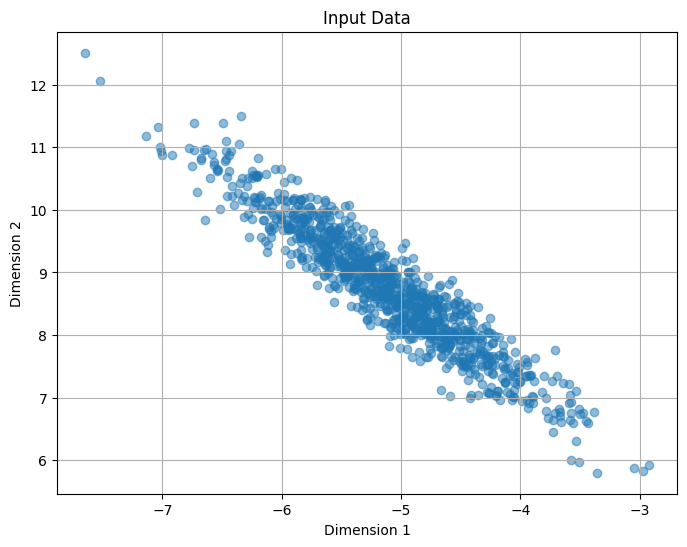

In [8]:
def plot_data(data):
    """Plot 2D data using a scatter plot."""
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
    plt.title('Input Data')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()

plot_data(data)


In [9]:
class VAE(nn.Module):
    def __init__(self, input_dim=2, latent_dim=2):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc11 = nn.Linear(50, 50)
        self.fc12 = nn.Linear(50, 50)
        self.fc21 = nn.Linear(50, latent_dim)  # For mu
        self.fc22 = nn.Linear(50, latent_dim)  # For log variance

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 200)
        self.fc4 = nn.Linear(200, 200)
        self.fc5 = nn.Linear(200, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.sigmoid(self.fc4(h3))
        return F.sigmoid(self.fc5(h4))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def encode_latent(self, x):
        with torch.no_grad():
            mu, _ = self.encode(x)
            return mu

In [10]:
x =torch.tensor([[1,2],
                [-1,5],
                 [-10,1]])
print(torch.min(x))

tensor(-10)


In [11]:
def loss_function(recon_x, x, mu, logvar):
    beta = 1.
    data_min = torch.min(x)
    data_max = torch.max(x)

    assert data_max != data_min
    data_centered = (x - data_min) /(data_max -data_min)

    BCE = F.binary_cross_entropy(recon_x, data_centered, reduction='sum')
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KL

In [12]:
model = VAE()
optimizer = Adam(model.parameters(), lr=3e-4)
data_loader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)


In [13]:
for epoch in range(10):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(data_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        # print(recon_batch)
        # print(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(data_loader.dataset)}] Loss: {loss.item() / len(data):.6f}"
            )


Train Epoch: 0 [0/1000] Loss: 3.884517
Train Epoch: 0 [640/1000] Loss: 2.596240
Train Epoch: 1 [0/1000] Loss: 2.060508
Train Epoch: 1 [640/1000] Loss: 1.320359
Train Epoch: 2 [0/1000] Loss: 1.156232
Train Epoch: 2 [640/1000] Loss: 0.907570
Train Epoch: 3 [0/1000] Loss: 0.806874
Train Epoch: 3 [640/1000] Loss: 0.797566
Train Epoch: 4 [0/1000] Loss: 0.708458
Train Epoch: 4 [640/1000] Loss: 0.656471
Train Epoch: 5 [0/1000] Loss: 0.689921
Train Epoch: 5 [640/1000] Loss: 0.661427
Train Epoch: 6 [0/1000] Loss: 0.730372
Train Epoch: 6 [640/1000] Loss: 0.529376
Train Epoch: 7 [0/1000] Loss: 0.675272
Train Epoch: 7 [640/1000] Loss: 0.699969
Train Epoch: 8 [0/1000] Loss: 0.749156
Train Epoch: 8 [640/1000] Loss: 0.743509
Train Epoch: 9 [0/1000] Loss: 0.874622
Train Epoch: 9 [640/1000] Loss: 0.663292


In [14]:
latent_variables = []
for data in data_loader:
    mu = model.encode_latent(data)
    latent_variables.append(mu)
latent_variables = torch.cat(latent_variables, 0)

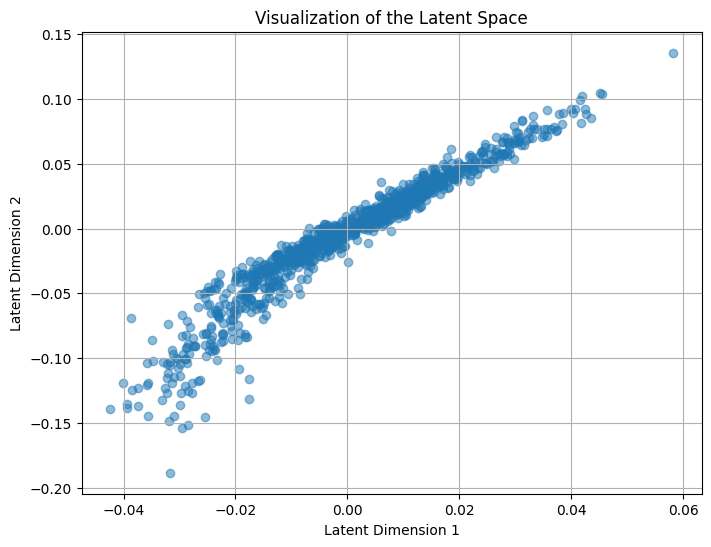

In [15]:

x, y = latent_variables[:, 0].numpy(), latent_variables[:, 1].numpy()

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Visualization of the Latent Space')
plt.grid(True)
plt.show()

In [16]:
def sample_from_vae(model, n_samples=100, device='cpu'):
    model.eval()
    with torch.no_grad():
        # Sample from a standard normal distribution
        z = torch.randn(n_samples, model.latent_dim).to(device) 
        # Decode the sample
        sampled_data = model.decode(z)
    return sampled_data


In [17]:
# Example of generating 10 new data points
n_samples = 1000
generated_data = sample_from_vae(model, n_samples=n_samples, device='cpu')

# Convert to numpy for visualization or further processing, if necessary
generated_data = generated_data.cpu().numpy()


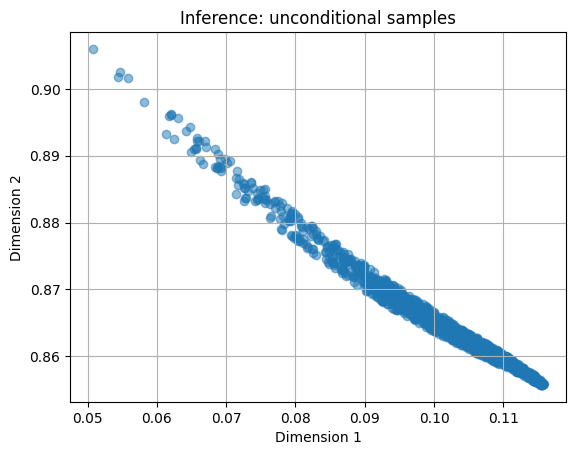

In [18]:
plt.scatter(generated_data[:, 0], generated_data[:, 1], alpha=0.5)
plt.title("Inference: unconditional samples")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()
